# Exploratory Data Analysis of Hand Gesture Image Dataset

## Setting Up Dataset Records and Information for Data Exploration

In [2]:
from PIL import Image
import imagehash
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import glob

columns = {
    'file_name': pd.Series(dtype='str'),
    'src': pd.Series(dtype='str'),
    'label_group': pd.Series(dtype='str'),
    'phash': pd.Series(dtype='str'),
}

dataset_label_group = {}

df = pd.DataFrame(columns=columns)
for filename in glob.iglob('data' + '**/**/*.png', recursive=True):
    fileNameChunks = filename.split('/')
    dfTemp = pd.DataFrame(columns=columns)
    image = Image.open(filename)
    phash = str(imagehash.average_hash(image))
    label_group = fileNameChunks[3].split('_')[1]
    dfTemp['file_name'] = [fileNameChunks[4]]
    dfTemp['src'] = [filename]
    dfTemp['label_group'] = [label_group]
    if label_group in dataset_label_group:
      dataset_label_group[label_group].append(filename)
    else:
      dataset_label_group[label_group] = [filename]
    dfTemp['phash'] = phash
    image.close()

    df = pd.concat([df, dfTemp], ignore_index=True)
df.head()


,file_name,src,label_group,phash
0,frame_451807_r.png,dataset/dataset-2/03/16_five/frame_451807_r.png,five,00100030b0306860
1,frame_453043_l.png,dataset/dataset-2/03/16_five/frame_453043_l.png,five,1018109919303810
2,frame_453845_l.png,dataset/dataset-2/03/16_five/frame_453845_l.png,five,0018001919183020
3,frame_452673_l.png,dataset/dataset-2/03/16_five/frame_452673_l.png,five,1018109959382030
4,frame_451912_l.png,dataset/dataset-2/03/16_five/frame_451912_l.png,five,0010003939302020


## Dataset categorization based on label group

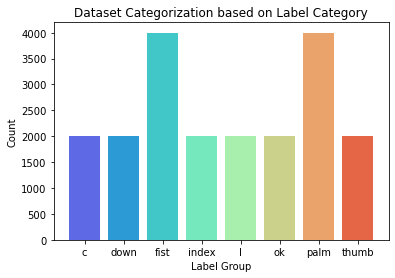

In [2]:
df_labe_group_count =  df[['label_group', 'src']].groupby(['label_group']).count().reset_index()

df_labe_group_count.columns = ['label_group', 'count']

sns.barplot(x='label_group', y='count', data=df_labe_group_count, palette='rainbow')
plt.xlabel('Label Group')
plt.ylabel('Count')
plt.title('Dataset Categorization based on Label Category')
plt.plot()
print()


<font color="red" >
Observation - This shows the variation in dataset among various label groups for the model.
</font>

## Comparing Image Hash
Comparing Image Hash to find relatively very similar images as they tend to have same hash values.

In [3]:
hash_df= df[['phash', 'label_group', 'src']].groupby(['phash', 'label_group']).count().reset_index()
hash_df.columns=['phash', 'label_group', 'count']
hash_df


,phash,label_group,count
0,0000000000383830,fist,1
1,0000000010383830,fist,8
2,0000000018383830,fist,3
3,0000000030303060,fist,58
4,0000000030703060,fist,4
...,...,...,...
1435,081c1c18183c3060,down,5
1436,0c0c1c18183c3060,down,1
1437,0c1c1c18183c3060,down,7
1438,1010101919181818,palm,1


In [4]:
hash_df_sample=df[df['phash']=='0018183838383020'].groupby(['label_group']).count()
hash_df_sample

,file_name,src,phash
label_group,,,
index,2,2,2
ok,4,4,4


<font color="red" >
Observations:
<ol>
<li>There are cases in which the same hash_value images belong to different groups. But it can be said that the majority belong to the same label_group only.</li>
<li>We are given a perceptual hashing value, hence for calculating the similarity between two images we will consider hamming distance.</li>
<li>Hash_value is also an important feature for a given image. We need to use it carefully with other available features to find out most similar images</li>
</font>

## Finding Mean image

Take the average value of each pixel across all observations and plot the average image.

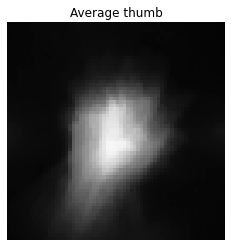

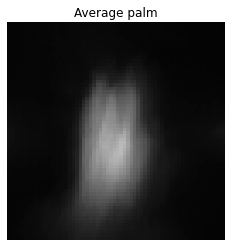

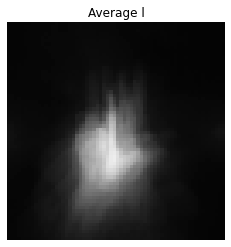

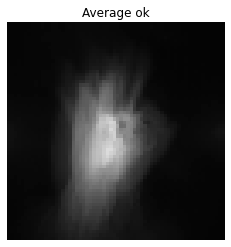

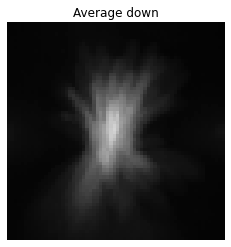

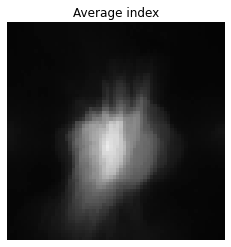

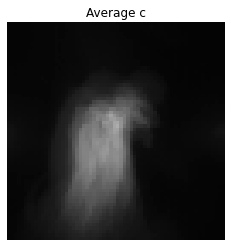

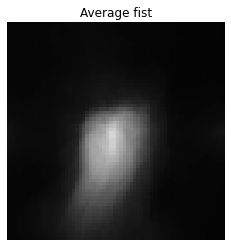

In [5]:
from tensorflow.keras.preprocessing import image
# making n X m matrix
def img2np(list_of_filename, size = (64, 64)):
    # iterating through each file
    for fp in list_of_filename:
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders

def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img
  

mean_images = {}

for label in dataset_label_group:
  dataset_label_group[label] = img2np(dataset_label_group[label])
  mean_images[label] = find_mean_img(dataset_label_group[label], label)


<font color="red" >
Observation - Since mean of the images in each label group are not very sharp implies that dataset is quite varying and not very similar. This shows that data quality is good and fit for further processing and training the model.
</font>

## PCA

Label: "thumb" - Number of PC:  5


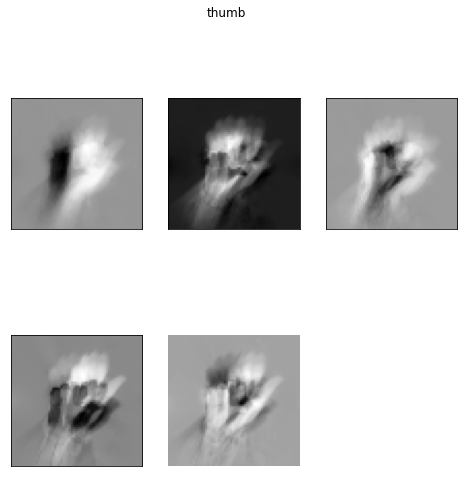

Label: "palm" - Number of PC:  4


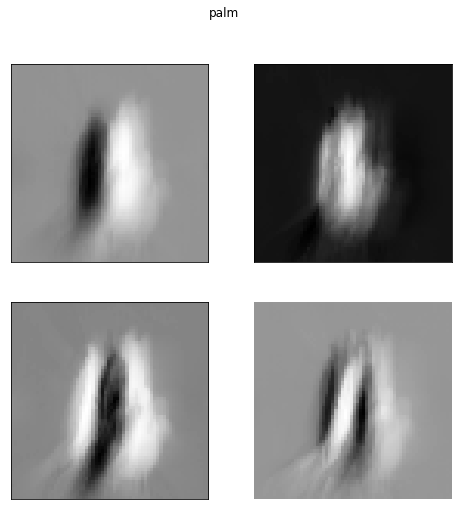

Label: "l" - Number of PC:  7


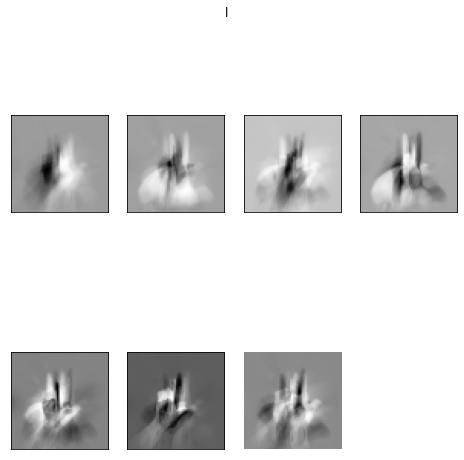

Label: "ok" - Number of PC:  6


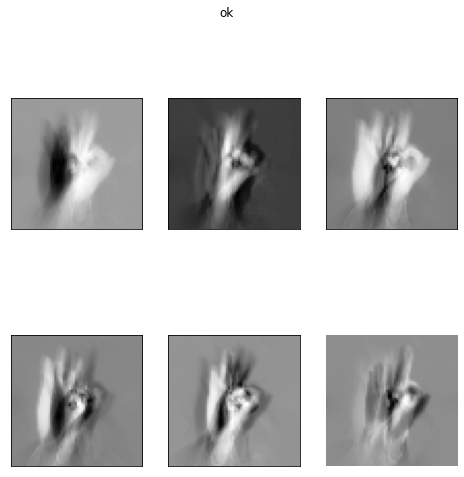

Label: "down" - Number of PC:  8


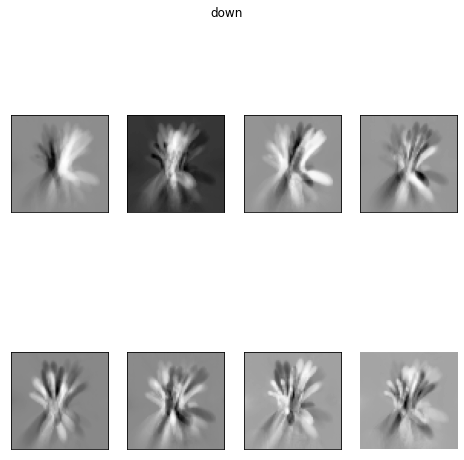

Label: "index" - Number of PC:  4


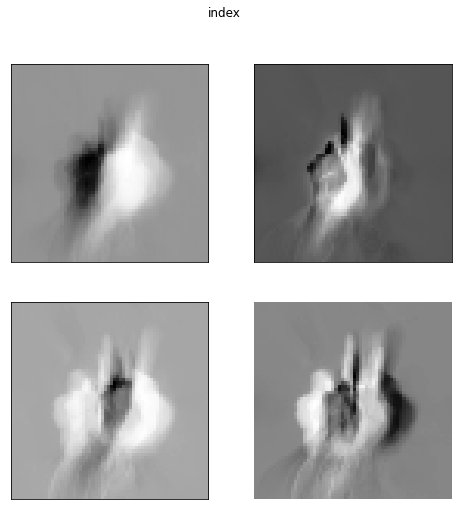

Label: "c" - Number of PC:  5


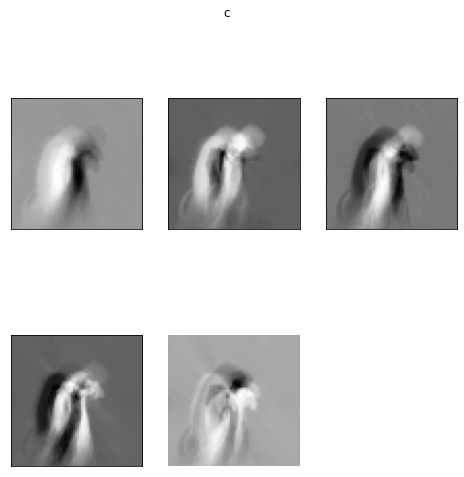

Label: "fist" - Number of PC:  6


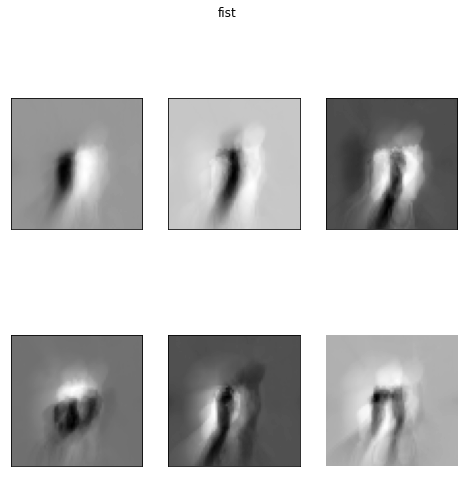

In [8]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print(f'Label: "{title}" - Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, title, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
        
    plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
for label in dataset_label_group:
  plot_pca(eigenimages(dataset_label_group[label], label), label)

<font color="red" >
Observation - We use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe each class the best. The eigenimages, which is essentially the eigenvectors (components) of PCA of our image matrix, can be reshaped into a matrix and be plotted. It’s also called eigenfaces as this approach was first used for facial recognition research. Here we will visualize the principal components that describe 70% of variability for each class.
</font>

In [12]:
a = df[['label_group', 'src']].groupby('label_group').count().reset_index()
a.columns = ['label_group', 'count']
a

,label_group,count
0,c,2000
1,down,2000
2,fist,4000
3,index,2000
4,l,2000
5,ok,2000
6,palm,4000
7,thumb,2000
